<a href="https://colab.research.google.com/github/suchitsharma2004/Convolutional_Neural_Network/blob/main/ResNet50V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow

In [2]:
!pip install opendatasets
!pip install pandas
!pip install tensorflow

In [4]:
import opendatasets as od
import pandas


od.download("https://www.kaggle.com/datasets/omkarmanohardalvi/lungs-disease-dataset-4-types")


100%|██████████| 2.02G/2.02G [01:58<00:00, 18.4MB/s]


In [5]:
import cv2
import tensorflow as tf
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

In [6]:
train_path = 'lungs_4/Diseases/train'
test_path = 'lungs_4/Diseases/test'

In [7]:
class_names=os.listdir(train_path)
class_names_test=os.listdir(test_path)

In [8]:
print(class_names)
print(class_names_test)

['Viral Pneumonia', 'Corona Virus Disease', 'Normal', 'Bacterial Pneumonia', 'Tuberculosis']
['Viral Pneumonia', 'Corona Virus Disease', 'Normal', 'Bacterial Pneumonia', 'Tuberculosis']


In [9]:


train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('lungs_4/Diseases/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('lungs_4/Diseases/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')


Found 6054 images belonging to 5 classes.
Found 2025 images belonging to 5 classes.


In [10]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

In [11]:
IMAGE_SIZE = [224, 224]
from glob import glob

In [12]:
ress = ResNet50V2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in ress.layers:
  layer.trainable = False



  # useful for getting number of classes
folders = glob('lungs_4/Diseases/train/*')

94668760/94668760 [==============================] - 5s 0us/step


In [13]:
x = Flatten()(ress.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=ress.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [14]:
from keras.callbacks import EarlyStopping
early=EarlyStopping(monitor='val_accuracy',min_delta=0, patience=20, verbose=1,mode='auto')

In [15]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=30,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set) , callbacks=[early]
)

<ipython-input-15-00b996a596cd>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/30
190/190 [==============================] - 203s 990ms/step - loss: 3.3102 - accuracy: 0.7317 - val_loss: 4.0179 - val_accuracy: 0.7185
Epoch 2/30
190/190 [==============================] - 192s 1s/step - loss: 2.9279 - accuracy: 0.8120 - val_loss: 3.9524 - val_accuracy: 0.7733
Epoch 3/30
190/190 [==============================] - 186s 976ms/step - loss: 2.5960 - accuracy: 0.8246 - val_loss: 3.4316 - val_accuracy: 0.8133
Epoch 4/30
190/190 [==============================] - 184s 965ms/step - loss: 2.3462 - accuracy: 0.8432 - val_loss: 3.9156 - val_accuracy: 0.8163
Epoch 5/30
190/190 [==============================] - 185s 972ms/step - loss: 2.2568 - accuracy: 0.8599 - val_loss: 5.2337 - val_accuracy: 0.8044
Epoch 6/30
190/190 [==============================] - 182s 956ms/step - loss: 2.5227 - accuracy: 0.8632 - val_loss: 3.5495 - val_accuracy: 0.8301
Epoch 7/30
190/190 [==============================] - 180s 948ms/step - loss: 2.0619 - accuracy: 0.8750 - val_loss: 4.3015 - va

In [16]:
import matplotlib.pyplot  as plt

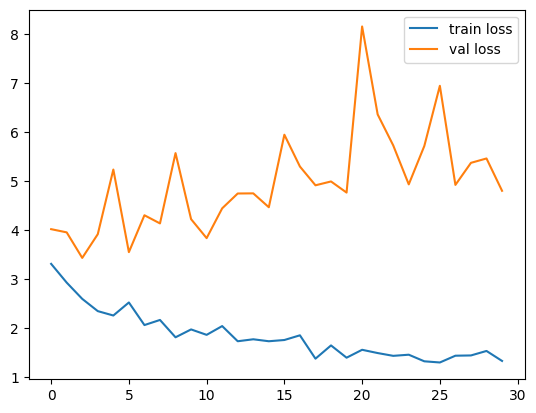

<Figure size 640x480 with 0 Axes>

In [17]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

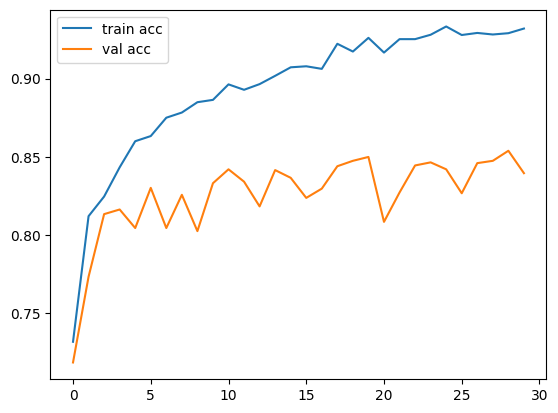

<Figure size 640x480 with 0 Axes>

In [18]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [19]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Y_pred = model.predict_generator(test_set, test_set.samples //
32+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_set.classes, y_pred))

<ipython-input-19-ead2b5cc9d75>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_set, test_set.samples //


Confusion Matrix
[[ 62  76  81  80 104]
 [ 54  88  89  81  95]
 [ 62  75  79 103  85]
 [ 64  77  87  78 102]
 [ 66  65  74  97 101]]
